In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.optim as optim

import torchvision
import torchvision.transforms as T
import torchvision.ops as OPS

import matplotlib.pyplot as plt

In [2]:
!wget https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip
!unzip PennFudanPed

--2022-04-09 13:03:58--  https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip
Resolving www.cis.upenn.edu (www.cis.upenn.edu)... 158.130.69.163, 2607:f470:8:64:5ea5::d
Connecting to www.cis.upenn.edu (www.cis.upenn.edu)|158.130.69.163|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53723336 (51M) [application/zip]
Saving to: ‘PennFudanPed.zip’

PennFudanPed.zip    100%[===================>]  51.23M  62.1MB/s    in 0.8s    

2022-04-09 13:03:59 (62.1 MB/s) - ‘PennFudanPed.zip’ saved [53723336/53723336]

Archive:  PennFudanPed.zip
   creating: PennFudanPed/
  inflating: PennFudanPed/added-object-list.txt  
   creating: PennFudanPed/Annotation/
  inflating: PennFudanPed/Annotation/FudanPed00001.txt  
  inflating: PennFudanPed/Annotation/FudanPed00002.txt  
  inflating: PennFudanPed/Annotation/FudanPed00003.txt  
  inflating: PennFudanPed/Annotation/FudanPed00004.txt  
  inflating: PennFudanPed/Annotation/FudanPed00005.txt  
  inflating: PennFudanPed/Annotati

In [3]:
def vis(imgs, boxes=None, masks=None, imgs_per_row=5):
    is_batch = len(imgs.shape) == 4
    is_mask = masks is not None
    
    if is_batch:
        fig, ax = plt.subplots(nrows=int(np.ceil(len(imgs)/imgs_per_row)), ncols=imgs_per_row, figsize=(18, 18))
        ax = ax.flatten()
        for i, img in enumerate(imgs):
            vis_img = img * 255
            vis_img = vis_img.to(torch.uint8)
            if is_mask:
                vis_mask = torch.sum(masks[i], 0)
                vis_img *= vis_mask
            if boxes is not None:
                vis_img = torchvision.utils.draw_bounding_boxes(vis_img, boxes[i], width=1, colors=(255,255,0))

            ax[i].imshow(vis_img.permute(1, 2, 0))
    else:
        vis_img = imgs * 255    
        vis_img = vis_img.to(torch.uint8)
        if is_mask:
            vis_mask = torch.sum(masks, 0)
            vis_img *= vis_mask
        if boxes is not None:
            vis_img=torchvision.utils.draw_bounding_boxes(vis_img, boxes, width=1, colors=(255,255,0))
        plt.imshow(vis_img.permute(1,2,0))

    plt.show()

In [4]:
import os
import numpy as np
from PIL import Image


class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        if transforms is None:
            self.transforms = transforms
        else:
            self.transforms = transforms[0]
            self.input_size = transforms[1]
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        # load images and masks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask = Image.open(mask_path)
        # convert the PIL Image into a numpy array
        mask = np.array(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        # convert everything into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd


        if self.transforms is not None:
            target = self.rescale_target(target, img)
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.imgs)

    def rescale_target(self, target, img):
        img_height, img_width = img.size
        rescaled_size = self.input_size
        
        h_coef = rescaled_size / img_height
        w_coef = rescaled_size / img_width

        # rescaling coords and area of boxes
        for j in range(len(target["boxes"])):
            # rescaling area of boxes
            target["area"][j] *= h_coef * w_coef

            # coords rescaling
            for i in range(4):
                if i % 2:
                    coef = w_coef
                else:
                    coef = h_coef
                # target["boxes"][j][i] = torch.ceil(target["boxes"][j][i] * coef)
                target["boxes"][j][i] *= coef
                
        # rescaling mask. IDK if it will work.
        target["masks"] = T.Resize((rescaled_size, rescaled_size))(target["masks"])

        return target

In [5]:
def get_transform(train: bool, input_size: int):
    trans = [T.ToTensor(), 
            T.Resize((input_size, input_size))]
    if train:
        trans.append(T.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.2))
        trans.append(T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)))

    transform = T.Compose(trans)
    return transform, input_size

In [6]:
INPUT_SIZE = 256

dataset_tr = PennFudanDataset('PennFudanPed', get_transform(train=False, input_size=INPUT_SIZE))
dataset_te = PennFudanDataset('PennFudanPed', get_transform(train=False, input_size=INPUT_SIZE))

indices = torch.randperm(len(dataset_tr)).tolist()
dataset_tr = torch.utils.data.Subset(dataset_tr, indices[:-50])
dataset_te = torch.utils.data.Subset(dataset_te, indices[-50:])

In [7]:
def collate_fn(batch):
    data_list, label_list = [], []
    for _data, _label in batch:
        data_list.append(_data)
        label_list.append(_label)
    return torch.stack(data_list), label_list

BATCH_SIZE = 4

dataloader_tr = torch.utils.data.DataLoader(dataset_tr, BATCH_SIZE, shuffle=True, num_workers=2, collate_fn=collate_fn)
dataloader_te = torch.utils.data.DataLoader(dataset_te, BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

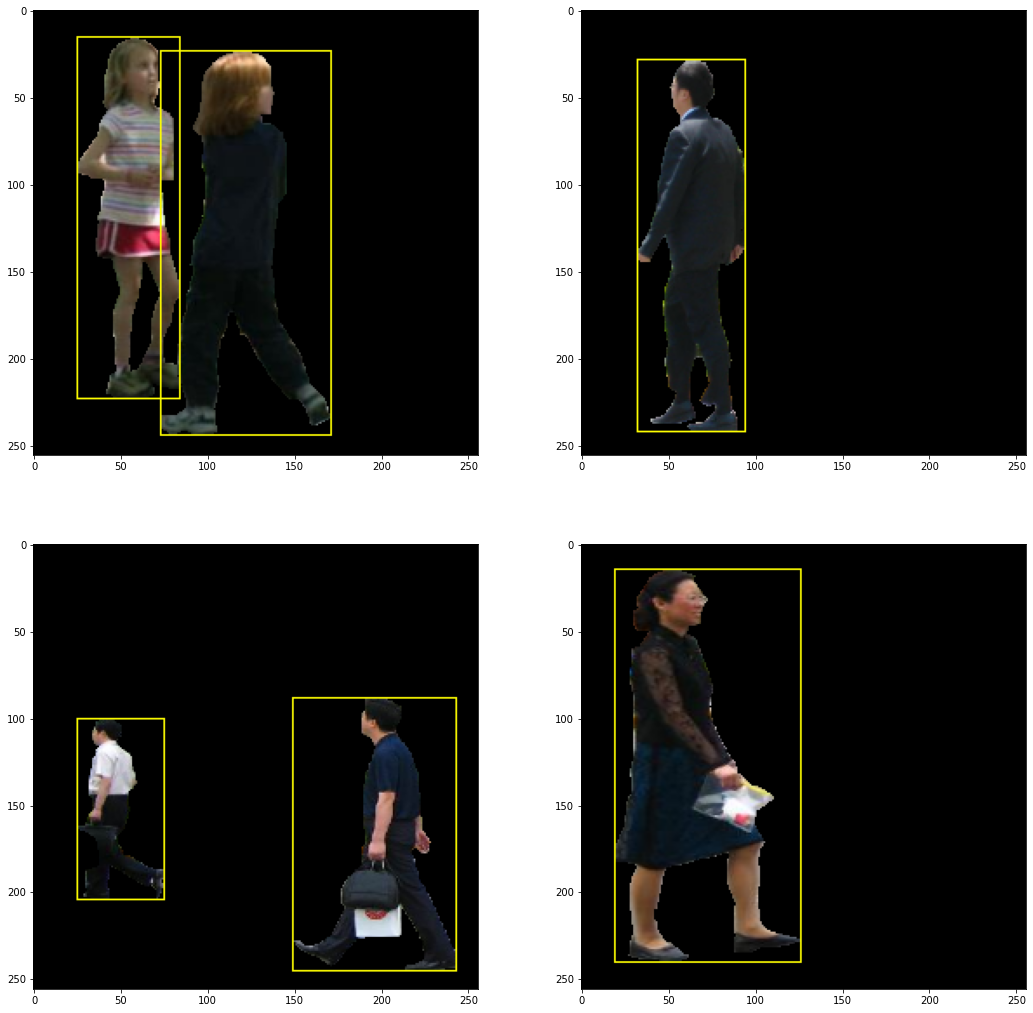

In [8]:
train_iter = iter(dataloader_tr)
x, target = next(train_iter)
boxes = [i["boxes"] for i in target]
masks = [i["masks"] for i in target]

vis(x, boxes, masks, imgs_per_row=2)

In [9]:
class BoxRegressor(nn.Module):
    def __init__(self):
        super(BoxRegressor, self).__init__()

        self.layers = nn.Sequential(
            nn.Linear(4, 16),
            nn.LeakyReLU(),
            nn.Linear(16, 4),
            nn.LeakyReLU()
        )

    def forward(self, x):
        return self.layers(x)

class MultiBoxRegressor(nn.Module):
    def __init__(self):
        super(MultiBoxRegressor, self).__init__()

        self.layers = nn.Sequential(
            nn.Linear(8, 32),
            nn.LeakyReLU(),
            nn.Linear(32, 8),
            nn.LeakyReLU()
        )

    def forward(self, x):
        return self.layers(x)

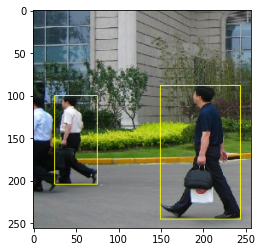

In [10]:
num = 2

train_img = x[num].reshape(1, 3, 256, 256)
target_box = boxes[num]

vis(train_img[0], target_box)

train_box = torch.rand(1, 4) * 256

In [11]:
"""
Jeśli mamy tutaj dwa obrazki do zmatchowania czyli target_box to tensor (2, 4) a train_box to tensor (1, 4)
to tak jakby mamy jeden box, który chcemy wykorzystać do zmatchowania do tych dwóch
to jak to robimy to liczymy mse train_box do pierwszego target_boxa a potem mse train_box do drugiego target_boxa
następnie sumujemy te mse i robimy backprop.

W rezultacie box próbuje możliwie najlepiej dopasować się do dwóch target_boxów.

Tutaj to zadziałało trochę niezamierzenie, gdyż target_box_hat ma inny dim od target_box (1, 4) do (2, 4) respektywnie.
Działa to dzięki broadcastingowi, czyli liczy się mse dla pierwszego potem dla drugiego target_boxa a następnie dzieli na dwa.
Efektywnie uzyskujemy to co chcieliśmy.
"""

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

net = BoxRegressor()
net.to(device)

criterion = nn.SmoothL1Loss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.05)

EPOCHS = 100

vis(train_img[0], train_box)

for epoch in range(EPOCHS):
    optimizer.zero_grad()
    target_box_hat = net.forward(train_box)
    loss = criterion(target_box_hat, target_box)
    loss.backward()
    # print(loss)
    optimizer.step()
    vis(train_img[0], target_box_hat)


print(target_box_hat)

Output hidden; open in https://colab.research.google.com to view.

In [12]:
test_random_box = torch.tensor([[ 77.4743,  19.7237, 108.6578, 172.9210]])
test_target_box = torch.tensor(
    [[137.6416,  64.3005, 229.4026, 230.7606], 
     [  0.6649,  64.3005,  57.1844, 230.1596]])

broad = criterion(test_random_box, test_target_box)
first_mse_part = criterion(test_random_box, test_target_box[0].reshape(1, 4))
second_mse_part = criterion(test_random_box, test_target_box[1].reshape(1, 4))
print(broad, (first_mse_part+second_mse_part)/2)

"""To nie zadziała ponieważ wymiary nie będą się zgadzać"""
# flat = criterion(test_random_box, test_target_box.flatten())
"""Gdybyśmy chcieli to policzyć po bożemu, to trzeba by to zrobić tak jak policzyliśmy first_mse_part i second_mse_part, następnie je zsumować i zrobić backprop na tej sumie """

tensor(63.6783) tensor(63.6783)


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:912: UserWarning: Using a target size (torch.Size([2, 4])) that is different to the input size (torch.Size([1, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)


'Gdybyśmy chcieli to policzyć po bożemu, to trzeba by to zrobić tak jak policzyliśmy first_mse_part i second_mse_part, następnie je zsumować i zrobić backprop na tej sumie '

In [13]:
train_box = torch.rand(2, 4) * 256
print(train_box)

tensor([[182.1475, 166.5376, 175.3642,  97.9433],
        [234.5072,  95.5394,  90.8983,  36.4536]])


In [14]:
"""
Tutaj korzystamy z trochę innej architektury sieci
na input przyjmujemy 8 liczb czyli 2x4 gdzie każda czwórka reprezentuje jednego bounding boxa.
na output mamy otrzymać też 8 liczb będących przewidzianą parą bounding boxów
"""

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

multi_net = MultiBoxRegressor()
multi_net.to(device)

criterion = nn.SmoothL1Loss()
optimizer = torch.optim.Adam(multi_net.parameters(), lr=0.05)

EPOCHS = 100

vis(train_img[0], train_box)

for epoch in range(EPOCHS):
    optimizer.zero_grad()
    target_box_hat = multi_net.forward(train_box.flatten())
    loss = criterion(target_box_hat, target_box.flatten())
    loss.backward()
    # print(loss)
    optimizer.step()
    vis(train_img[0], target_box_hat.reshape(2, 4))


print(target_box_hat)

Output hidden; open in https://colab.research.google.com to view.

In [19]:
class CustomMultiBoxRegressor(nn.Module):
    def __init__(self):
        super(CustomMultiBoxRegressor, self).__init__()

        self.layers = nn.Sequential(
            nn.Linear(8, 64),
            nn.LeakyReLU(),
            nn.Linear(64, 16),
            nn.LeakyReLU()
        )

    def forward(self, x):
        return self.layers(x)

In [33]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

multi_net = CustomMultiBoxRegressor()
multi_net.to(device)

criterion = nn.SmoothL1Loss()
optimizer = torch.optim.Adam(multi_net.parameters(), lr=0.05)

EPOCHS = 100

vis(train_img[0], train_box)

for epoch in range(EPOCHS):
    optimizer.zero_grad()
    target_box_hat = multi_net.forward(train_box.flatten())
    loss = 0
    target_box_hat = target_box_hat.reshape(2, 8)
    for i in range(len(target_box_hat)):
        loss += criterion(target_box_hat[i].flatten(), target_box.flatten())
    loss.backward()
    # print(loss)
    optimizer.step()
    vis(train_img[0], target_box_hat.reshape(4, 4))


print(target_box_hat)

Output hidden; open in https://colab.research.google.com to view.